In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import numpy as np
#import pandas as pd
import itertools
#from os import path
import math
import pandas as pd
import xarray as xr
import glob
import wrf
from wrf import getvar, interplevel,interpz3d

In [ ]:
'''
This code will read in a WRF file, process some of the data, and make a couple plots.
Modified from the script from https://atmos.colostate.edu/~btrabing/Read_WRF.html
Ben Trabing
Colorado State University
btrabing@colostate.edu
'''

In [2]:
import netCDF4
import numpy as np
from matplotlib import pyplot as plt

def wrf_unstagger( grid, dim ):
    """ Unstagger a staggered WRF grid in the X, Y, or Z (U, V, or W) direction.
        ---------------------
        grid (numpy.ndarray): The 2D, 3D, 4D, or 5D array to be unstaggered.
        dim (str): A string specifying what dimension to unstagger. Must be
        X, Y, Z, U, V or W.
        ---------------------
        returns:
        numpy.ndarray unstaggered grid (dim-1)
        ---------------------
        EXAMPLE:
        import numpy as np

        arr = np.random.randint( low=1, high=10, size=( 9,10,9 ) ) ## create a random array staggered in the Y direction
        arr_unstaggered = wrf_unstagger( arr, 'Y' )
        """
    nd = len( grid.shape )
    if dim == 'X' or dim == 'U':
        if nd == 4:
            gridout = ( grid[ :, :, :, :-1 ] + grid[ :, :, :, 1: ] ) / 2.
        else: pass
    if dim == 'Y' or dim == 'V':
        if nd == 4:
            gridout = ( grid[ :, :, :-1, : ] + grid[ :, :, 1:, : ] ) / 2.
        else: pass
    if dim == 'Z' or dim == 'W':
        if nd == 4:
            gridout = ( grid[ :, :-1, :, : ] + grid[ :, 1:, :, : ] ) / 2.
        else: pass
    return gridout



def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa

def wrf_rho(TEMP,PRES):
    return PRES/(283.14*TEMP)

def wrf_rh(TEMP,PRES,MXRAT):
    A= 6.11*100. #Pa
    Rv = 461.495 #J/kg/K
    Lv = 2.453*10**6 #J/Kg
    
    ES = A*np.exp((Lv/Rv)*((1./273.)-(1./TEMP))) #in Pa
    SMXRAT = ((621.97*ES)/(PRES-ES))/1000.
    return (MXRAT/SMXRAT)*100.



def get_wrf_var(var,file_path):
    '''
    Requirements: 
    import netCDF4
    
    This function will read in a wrf file and the desired variable 
    The input is the variable name and the location of the file
    The output is an array of the desired variable in the native units
    example: get_wrf_var('PSFC','/location/to/file')    
    '''
    ncfile = netCDF4.Dataset(file_path,mode='r')
    ncvar = ncfile.variables[var][:]
    ncfile.close()
    return ncvar



def pres_interp(var,surface,new_height): 
    '''
    Takes a wrf variable like u,v,w, and/or mixing ratios and linearly interpolates it to pressure surfaces
    
    input: variable with 4D (time, height, x, y), the pressure surface as the same 4D variable, and the pressure
    levels that you want to interpolate to
    output: variable with 4D (time, new height, x, y)
    
    import numpy as np
    
    Note: np.interp requires the arrays to be increasing, so since we are interpolating to pressure coords
    we have to reverse the direction
    '''
    
    #######################
    #These are the pressure levels to interpolate to if you want to define them here
    #new_height = np.array([1000,850,700,500,200,100]) 
    #######################
    
    new_surf = np.empty((var.shape[0],new_height.shape[0],var.shape[2],var.shape[3]))

    for TIM in np.arange(var.shape[0]): #Loop over all the time periods
        for IDX, VAL in np.ndenumerate(var[0][0]): #Loop over all the points
            new_val = np.interp(new_height,surface[TIM,::-1,IDX[0],IDX[1]],var[TIM,::-1,IDX[0],IDX[1]], right=np.nan)
            new_surf[TIM,:,IDX[0],IDX[1]]=new_val[:] #put the interpolated profile into the new array
    return new_surf

In [163]:
#read in wrf output files
wrfout_dir='/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_900m/'
wrfout_filelist=glob.glob(wrfout_dir+'wrfout_*')
#calculate the grid index of the sw & ne corner of the selected region
#xy_sw=wrf.ll_to_xy(ncfile,43.51,-116.65).data
x_min=-116.60
x_max=-115.28
y_min=44.11
y_max=44.3
xy_sw1=wrf.ll_to_xy(ncfile,y_min,x_min).data
xy_ne1=wrf.ll_to_xy(ncfile,y_max,x_max).data
x_min=-116.8
x_max=-116.2
y_min=43.45
y_max=44.21
xy_sw2=wrf.ll_to_xy(ncfile,y_min,x_min).data
xy_ne2=wrf.ll_to_xy(ncfile,y_max,x_max).data

nfile=0
for wrfout_file in wrfout_filelist:
    if int(wrfout_filelist[1][85:87])>=14 and int(wrfout_filelist[1][85:87])<=17:
        ncfile = Dataset(wrfout_file,mode='r')
        p = getvar(ncfile, "pressure")
        ht = getvar(ncfile, "z", msl=True,units="m")
        tk = getvar(ncfile,"tk")
        rho=p*100/(283.14*tk)
        qncloud=getvar(ncfile,"QNCLOUD")
        ncloud=qncloud*rho/1e6
        #ht_500 = interpz3d(ht, p, 500.0)
        #interpolate to height MSL
        ncloud_4876 = interplevel(ncloud, ht, 4876.0)#16,000feet
        ncloud_4572 = interplevel(ncloud, ht, 4572.0)

        #get average droplet number concentration over the region
        ncloud_region1=ncloud_4876[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        ncloud_region1=ncloud_region1.reshape(ncloud_region1.size,)
        ncloud_region2=ncloud_4572[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        ncloud_region2=ncloud_region2.reshape(ncloud_region2.size,)
        ncloud_region3=ncloud_4572[xy_sw2[1]-1:xy_ne2[1]+1,xy_sw2[0]-1:xy_ne2[0]+1].data
        ncloud_region3=ncloud_region3.reshape(ncloud_region3.size,)
        ncloud_regions=np.hstack((ncloud_region1,ncloud_region2,ncloud_region3))
        non_zero_ncloud1=ncloud_region1[np.nonzero(ncloud_region1)]
        non_zero_ncloud2=ncloud_region2[np.nonzero(ncloud_region2)]
        non_zero_ncloud3=ncloud_region3[np.nonzero(ncloud_region3)]
        non_zero_nclouds=ncloud_regions[np.nonzero(ncloud_regions)]
        if nfile == 0:
            NCLOUD_R1_series=non_zero_ncloud1
            NCLOUD_R2_series=non_zero_ncloud2
            NCLOUD_R3_series=non_zero_ncloud3
            NCLOUD_ALL_series=non_zero_nclouds
        else:
            NCLOUD_R1_series=np.append(NCLOUD_R1_series,non_zero_ncloud1)
            NCLOUD_R2_series=np.append(NCLOUD_R2_series,non_zero_ncloud2)
            NCLOUD_R3_series=np.append(NCLOUD_R3_series,non_zero_ncloud3)
            NCLOUD_ALL_series=np.append(NCLOUD_ALL_series,non_zero_nclouds)
        #np.nonzero(ncloud_select_region)
        nfile=nfile+1
        print('process ',nfile,' out of ',len(wrfout_filelist),' files')
print('Finished')

Finished


In [164]:
NCLOUD_ALL_series.size

162324

In [162]:
#calculate statistics
non_zero_ncloud=NCLOUD_ALL_series#np.append(non_zero_ncloud1,non_zero_ncloud2)
max_ncloud=non_zero_ncloud.max()
mean_ncloud=non_zero_ncloud.mean()
min_ncloud=non_zero_ncloud.min()
n5=np.percentile(non_zero_ncloud, 5) 
n25=np.percentile(non_zero_ncloud, 25) 
n50=np.percentile(non_zero_ncloud, 50)
n75=np.percentile(non_zero_ncloud, 75)
n95=np.percentile(non_zero_ncloud, 95) 
print(min_ncloud,max_ncloud,mean_ncloud)
print(n5,n25,n50,n75,n95)

0.00355564 252.53714 110.68776
15.088967323303223 63.687198638916016 111.81661987304688 161.94427490234375 192.93885803222656


In [8]:
def get_plot_element(infile):
    rootgroup = nc.Dataset(infile, 'r')
    p = wrf.getvar(rootgroup, 'RAINNC')
    #lats, lons = wrf.latlon_coords(p)
    cart_proj = wrf.get_cartopy(p)
    xlim = wrf.cartopy_xlim(p)
    ylim = wrf.cartopy_ylim(p)
    rootgroup.close()
    return cart_proj, xlim, ylim

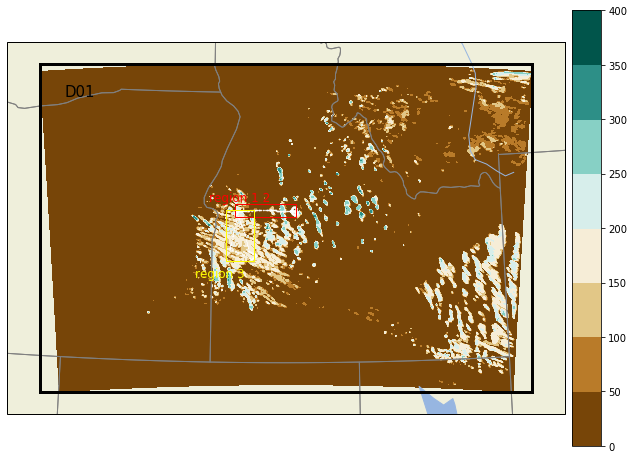

In [116]:
#plot the region that covers IOP22 UWKA KML
cart_proj, xlim_d01, ylim_d01 = get_plot_element(wrfout_file)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, edgecolor='gray')
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
# d01
ax.set_xlim([xlim_d01[0]-(xlim_d01[1]-xlim_d01[0])/15, xlim_d01[1]+(xlim_d01[1]-xlim_d01[0])/15])
ax.set_ylim([ylim_d01[0]-(ylim_d01[1]-ylim_d01[0])/15, ylim_d01[1]+(ylim_d01[1]-ylim_d01[0])/15])


# d01 box
ax.add_patch(mpl.patches.Rectangle((xlim_d01[0], ylim_d01[0]), xlim_d01[1]-xlim_d01[0], ylim_d01[1]-ylim_d01[0],
             fill=None, lw=3, edgecolor='black', zorder=10))
ax.text(xlim_d01[0]+(xlim_d01[1]-xlim_d01[0])*0.05, ylim_d01[0]+(ylim_d01[1]-ylim_d01[0])*0.9, 'D01',
        size=15, color='black', zorder=10)

# flight region box 1
LAT = ncfile.variables['XLAT'][:].data
LON = ncfile.variables['XLONG'][:].data
lon_min=LON.min()
lon_max=LON.max()
lon_mid=(lon_min+lon_max)/2
lat_min=LAT.min()
lat_max=LAT.max()
lat_mid=(lat_min+lat_max)/2

def coord_transform(lon,lon_min,lon_max,xlim_d01):
    x=(lon-lon_min)/(lon_max-lon_min)*(xlim_d01[1]-xlim_d01[0])+xlim_d01[0]
    return x

x_min=-116.60
x_max=-115.28
y_min=44.11
y_max=44.3
xmin1=coord_transform(x_min,lon_min,lon_max,xlim_d01)
x_width1=coord_transform(x_max,lon_min,lon_max,xlim_d01)-xmin1
ymin1=coord_transform(y_min,lat_min,lat_max,ylim_d01)
y_height1=coord_transform(y_max,lat_min,lat_max,ylim_d01)-ymin1

ax.add_patch(mpl.patches.Rectangle((xmin1, ymin1), width=x_width1, height=y_height1,fill=None, lw=1, edgecolor='red', zorder=10))

x_min=-116.8
x_max=-116.2
y_min=43.45
y_max=44.21
xmin2=coord_transform(x_min,lon_min,lon_max,xlim_d01)
x_width2=coord_transform(x_max,lon_min,lon_max,xlim_d01)-xmin2
ymin2=coord_transform(y_min,lat_min,lat_max,ylim_d01)
y_height2=coord_transform(y_max,lat_min,lat_max,ylim_d01)-ymin2

ax.add_patch(mpl.patches.Rectangle((xmin2, ymin2), width=x_width2, height=y_height2,fill=None, lw=1, edgecolor='yellow', zorder=10))
ax.text(1.5*xmin1, 2.5*ymin1, 'region 1 2',
        size=12, color='red', zorder=10)
ax.text(1.5*xmin2, 1.5*ymin2, 'region 3 ',
        size=12, color='yellow', zorder=10)
lon_x=coord_transform(LON,lon_min,lon_max,xlim_d01)
lat_y=coord_transform(LAT,lat_min,lat_max,ylim_d01)
im=ax.contourf(lon_x[0,:,:],lat_y[0,:,:],ncloud_4572 ,cmap=plt.cm.BrBG)
cb_ax = fig.add_axes([.91,.124,.04,.756])
cbar = fig.colorbar(im,orientation='vertical',cax=cb_ax)
ax.scatter(x_series, y_series,s=0.1,color='white') 


In [68]:
IOP_UWKA_file='/glade/u/home/sisichen/scratch/WRF_SNOWIE/Analysis/IOP22_UWKA'
IOP22_data=pd.read_csv(IOP_UWKA_file,index_col=False, header = None, names=\
                ['Lon','Lat','Alt'])
x_series=coord_transform(IOP22_data.Lon,lon_min,lon_max,xlim_d01)
y_series=coord_transform(IOP22_data.Lat,lat_min,lat_max,ylim_d01)
#x_series=(IOP22_data.Lon-lon_min)/(lon_max-lon_min)*(xlim_d01[1]-xlim_d01[0])+xlim_d01[0]

In [39]:
def coord_transform(lon,lon_min,lon_max,xlim_d01):
    x=(lon-lon_min)/(lon_max-lon_min)*(xlim_d01[1]-xlim_d01[0])+xlim_d01[0]
    return x
x_min=-116.60
x_max=-115.28
y_min=44.11
y_max=44.21
xmin1=(x_min-lon_min)/(lon_max-lon_min)*(xlim_d01[1]-xlim_d01[0])+xlim_d01[0]
xmin1_new=coord_transform(x_min,lon_min,lon_max,xlim_d01)
xmin1_new

-84274.24877661647

In [93]:
ncloud_4876.shape

(600, 900)

In [98]:
LON.shape

(1, 600, 900)

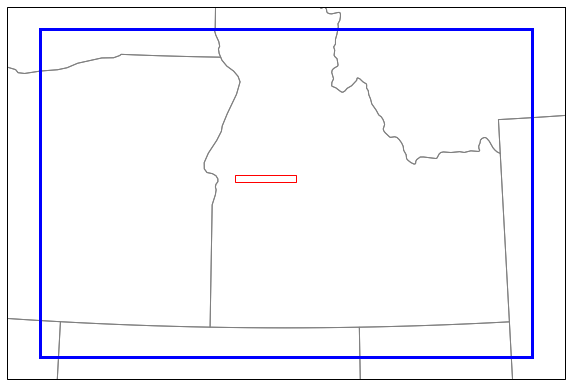

In [140]:

ax.add_patch(mpl.patches.Rectangle((xmin, ymin), width=x_width, height=y_height,fill=None, lw=1, edgecolor='red', zorder=10))

In [76]:
p = wrf.getvar(ncfile, 'RAINNC')
cart_proj = wrf.get_cartopy(p)

In [ ]:
# d01
ax.set_xlim([xlim_d01[0]-(xlim_d01[1]-xlim_d01[0])/15, xlim_d01[1]+(xlim_d01[1]-xlim_d01[0])/15])
ax.set_ylim([ylim_d01[0]-(ylim_d01[1]-ylim_d01[0])/15, ylim_d01[1]+(ylim_d01[1]-ylim_d01[0])/15])
 
# d01 box
ax.add_patch(mpl.patches.Rectangle((xlim_d01[0], ylim_d01[0]), xlim_d01[1]-xlim_d01[0], ylim_d01[1]-ylim_d01[0],
             fill=None, lw=3, edgecolor='blue', zorder=10))
ax.text(xlim_d01[0]+(xlim_d01[1]-xlim_d01[0])*0.05, ylim_d01[0]+(ylim_d01[1]-ylim_d01[0])*0.9, 'D01',
        size=15, color='blue', zorder=10)
 
# d02 box
ax.add_patch(mpl.patches.Rectangle((xlim_d02[0], ylim_d02[0]), xlim_d02[1]-xlim_d02[0], ylim_d02[1]-ylim_d02[0],
             fill=None, lw=3, edgecolor='black', zorder=10))
ax.text(xlim_d02[0]+(xlim_d02[1]-xlim_d02[0])*0.05, ylim_d02[0]+(ylim_d02[1]-ylim_d02[0])*1.1, 'D02',
        size=15, color='black', zorder=10)
 
# d03 box
ax.add_patch(mpl.patches.Rectangle((xlim_d03[0], ylim_d03[0]), xlim_d03[1]-xlim_d03[0], ylim_d03[1]-ylim_d03[0],
             fill=None, lw=3, edgecolor='red', zorder=10))
ax.text(xlim_d03[0]+(xlim_d03[1]-xlim_d03[0])*0.1, ylim_d03[0]+(ylim_d03[1]-ylim_d03[0])*0.8, 'D03',
        size=15, color='red', zorder=10)
 
ax.set_title('WRF nested domain setup (2010Nash event)', size=20)
 
plt.show()

In [9]:
#Can calculate other variables as needed
WVMIX = ncfile.variables['QVAPOR'][:]
RH = wrf_rh(TEMP,PRES*100.,WVMIX) #Needs to be in Pascals instead of hPa
U = ncfile.variables['U'][:]
V = ncfile.variables['V'][:]
QNCLOUD=ncfile.variables['QNCLOUD'][:]
#W = ncfile.variables['W'][:]
####################################
#Because of the C-staggered grid in WRF we need to get the velocities centered at the mass points of the grid boxes
#We can do this by averaging the 2 closest grid points to get an estimate of the center
U = wrf_unstagger(U, 'X' )
V = wrf_unstagger(V, 'Y' )
#W = wrf_unstagger(W, 'Z' )
#Interpolate RH,U,V to those pressure levels
PLevels = np.array([1000,850,700,500,200,100]) 
RH_ = pres_interp(RH,PRES,PLevels)
U_ = pres_interp(U,PRES,PLevels)
V_ = pres_interp(V,PRES,PLevels)

In [10]:
TIMES = ncfile.variables['Times'][:]

In [13]:
LAT[Time_Index].min()

41.46273

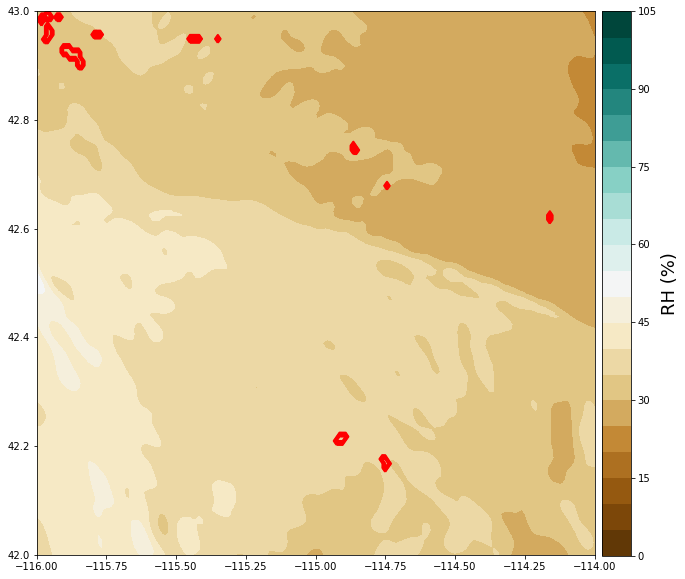

In [17]:
Time_Index = 0
Height_Index = 3


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


clev = np.arange(0,110,5) #Contour levels

#Plot the RH at the specified pressure level and time
im = ax.contourf(LON[Time_Index],LAT[Time_Index],RH_[Time_Index,Height_Index],clev,cmap=plt.cm.BrBG)

#Add the landmask
ax.contour(LON[Time_Index],LAT[Time_Index],LM[Time_Index],colors='red',linewidths=2)

#For barbs you may need to fiddle with the sampling frequency depending on your resolution and plot size
#xsf=15
#ysf=15
#ax.barbs(LON[Time_Index,::xsf,::ysf],LAT[Time_Index,::xsf,::ysf],U_[Time_Index,Height_Index,::xsf,::ysf],V_[Time_Index,Height_Index,::xsf,::ysf],color='k')

#Set the limits based on  min/max lat/lon. May need to modify for southern hemisphere and near the equator
ax.set_xlim(-116,-114)
ax.set_ylim(42,43)

#Add the title which will change based on the chosen Plevel
#ax.set_title('%s RH, Winds at %s hPa'%(''.join(TIMES[Time_Index]),PLevels[Height_Index]),fontsize=16)

#Add the colorbar
cb_ax = fig.add_axes([.91,.124,.04,.756])
cbar = fig.colorbar(im,orientation='vertical',cax=cb_ax)
cbar.set_label('RH (%)',size=18)


#Save the figure
plt.savefig('WRF_RH_Barbs_TI_%2.2d_PLEV_%2.2d.png'%(Time_Index,Height_Index),bbox_inches='tight')



plt.show()#Show the plot

In [20]:
TIMES.data[Time_Index]

array([b'2', b'0', b'1', b'7', b'-', b'0', b'3', b'-', b'0', b'9', b'_',
       b'1', b'5', b':', b'3', b'0', b':', b'0', b'0'], dtype='|S1')